In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Train and Test 
train = pd.read_csv('train_prepared_cabinnum_le.csv')
test  = pd.read_csv('test_prepared_cabinnum_le.csv')

print("Train shape:", train.shape)
print("Test shape :", test.shape)
print("\nTrain columns:", train.columns.tolist())

Train shape: (8693, 42)
Test shape : (4277, 41)

Train columns: ['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Alone', 'RoomService_missing', 'FoodCourt_missing', 'ShoppingMall_missing', 'Cabin_missing', 'VIP_missing', 'TotalExpense_missing', 'TotalExpense', 'CabinSide', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'GroupSize_1', 'GroupSize_2', 'GroupSize_3', 'GroupSize_4', 'GroupSize_5', 'GroupSize_6', 'GroupSize_7', 'GroupSize_8', 'CabinDeck_A', 'CabinDeck_B', 'CabinDeck_C', 'CabinDeck_D', 'CabinDeck_E', 'CabinDeck_F', 'CabinDeck_G', 'CabinDeck_T', 'CabinNum', 'Transported', 'kfold']


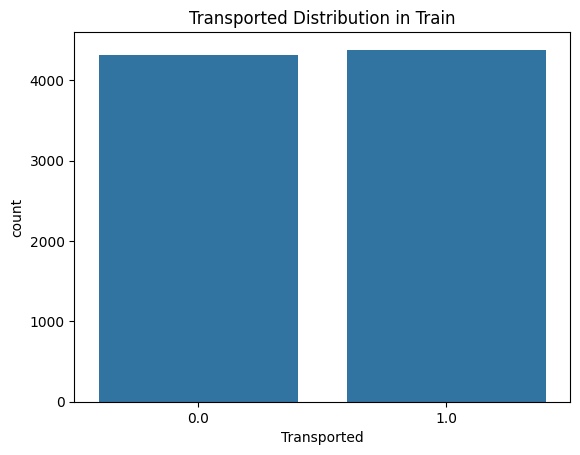

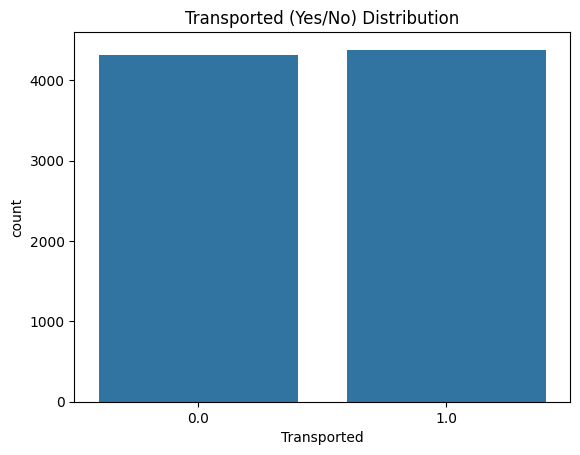

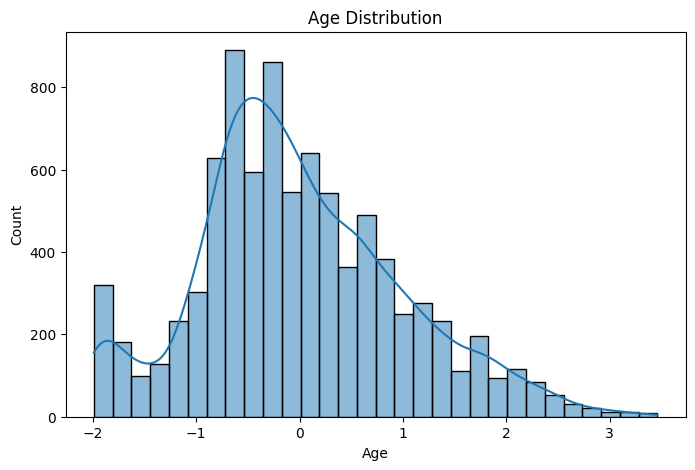


kfold counts:
 kfold
0    1739
2    1739
1    1739
3    1738
4    1738
Name: count, dtype: int64

Missing values:
 0


In [10]:
# Target distribution
sns.countplot(x='Transported', data=train)
plt.title('Transported Distribution in Train')
plt.show()

sns.countplot(x='Transported', data=train)
plt.title('Transported (Yes/No) Distribution')
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(train['Age'].dropna(), bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

# kfold distribution
print("\nkfold counts:\n", train['kfold'].value_counts())

# Missing values 
print("\nMissing values:\n", train.isnull().sum().sum())

In [9]:
# All columns except these three
exclude = ['Transported', 'kfold', 'PassengerId']

features = [col for col in train.columns if col not in exclude]

X = train[features]
y = train['Transported']

print("Number of features:", len(features))

Number of features: 40


In [6]:
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

scores = []

for fold in range(5):
    train_idx = train[train['kfold'] != fold].index
    val_idx   = train[train['kfold'] == fold].index
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    
    acc = accuracy_score(y_val, pred)
    scores.append(acc)
    
    print(f"Fold {fold} Accuracy: {acc:.4f}")

print(f"\nMean CV Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

Fold 0 Accuracy: 0.7890
Fold 1 Accuracy: 0.7953
Fold 2 Accuracy: 0.8033
Fold 3 Accuracy: 0.8113
Fold 4 Accuracy: 0.8015

Mean CV Accuracy: 0.8001 ± 0.0075


In [7]:
# Model Train
model.fit(X, y)
print("Final model trained on full data!")

Final model trained on full data!


In [11]:
# Test features (same columns as train)
X_test = test[features]

# Predict
test_predictions = model.predict(X_test)

# Create submission file
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Transported': test_predictions.astype(bool)   # True / False format required by Kaggle
})

submission.to_csv('submission_rf_cabinnum.csv', index=False)

print("Submission file created: submission_rf_cabinnum.csv")
print("\nFirst 8 rows of submission:")
print(submission.head(8))

Submission file created: submission_rf_cabinnum.csv

First 8 rows of submission:
  PassengerId  Transported
0     0013_01        False
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True
5     0027_01        False
6     0029_01         True
7     0032_01         True


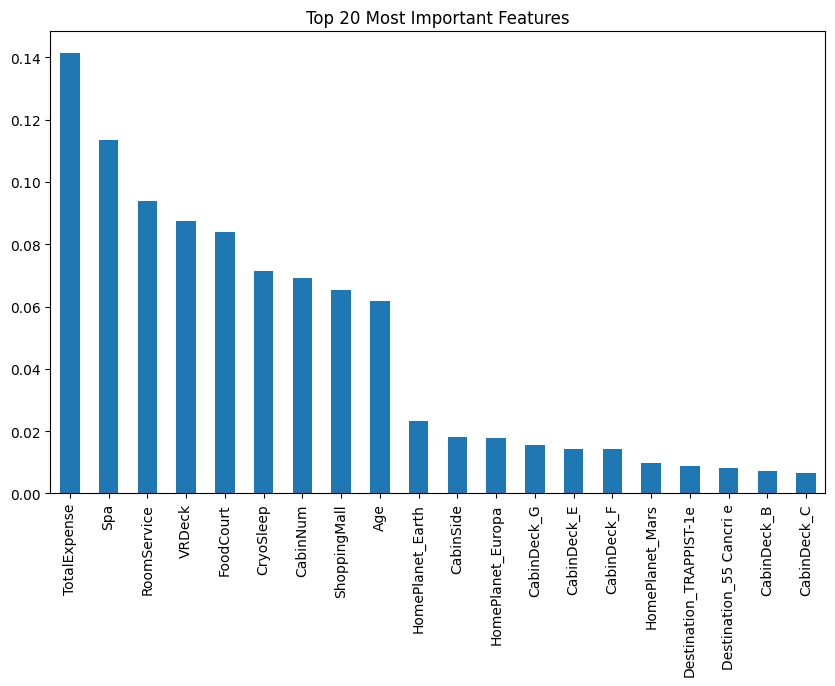

In [12]:
# After final model is trained
importances = pd.Series(model.feature_importances_, index=features)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importances.head(20).plot(kind='bar')
plt.title('Top 20 Most Important Features')
plt.show()